<a href="https://colab.research.google.com/github/boblef/detect_COVID19/blob/master/COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 3.8MB 33.7MB/s 
     |████████████████████████████████| 450kB 41.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

%matplotlib inline

In [0]:
data_path = '/content/drive/My Drive/covid19_img/'

In [9]:
covid_file_list = os.listdir(data_path + 'train/covid/')
covid_file_list = [data_path + 'train/covid/' + file_name for file_name in covid_file_list]
len(covid_file_list)

67

In [10]:
normal_file_list = os.listdir(data_path + 'train/normal/')
normal_file_list = [data_path + 'train/normal/' + file_name for file_name in normal_file_list]
len(normal_file_list)

67

In [0]:
def plot_samples(file_list, num_rows=5, num_cols=5, label='COVID-19', format='jpg'):
    chosen_files = random.sample(file_list, num_rows * num_cols)
    plt.figure(figsize=(20, 20))
    plt.title(label, fontsize=25)
    for index, file_name in enumerate(chosen_files):
        plt.subplot(num_rows, num_cols, index+1)
        plt.imshow(plt.imread(file_name, 'jpg'), cmap='gray')
    plt.show()
    # plt.savefig('/content/{}_samples.png'.format(label))

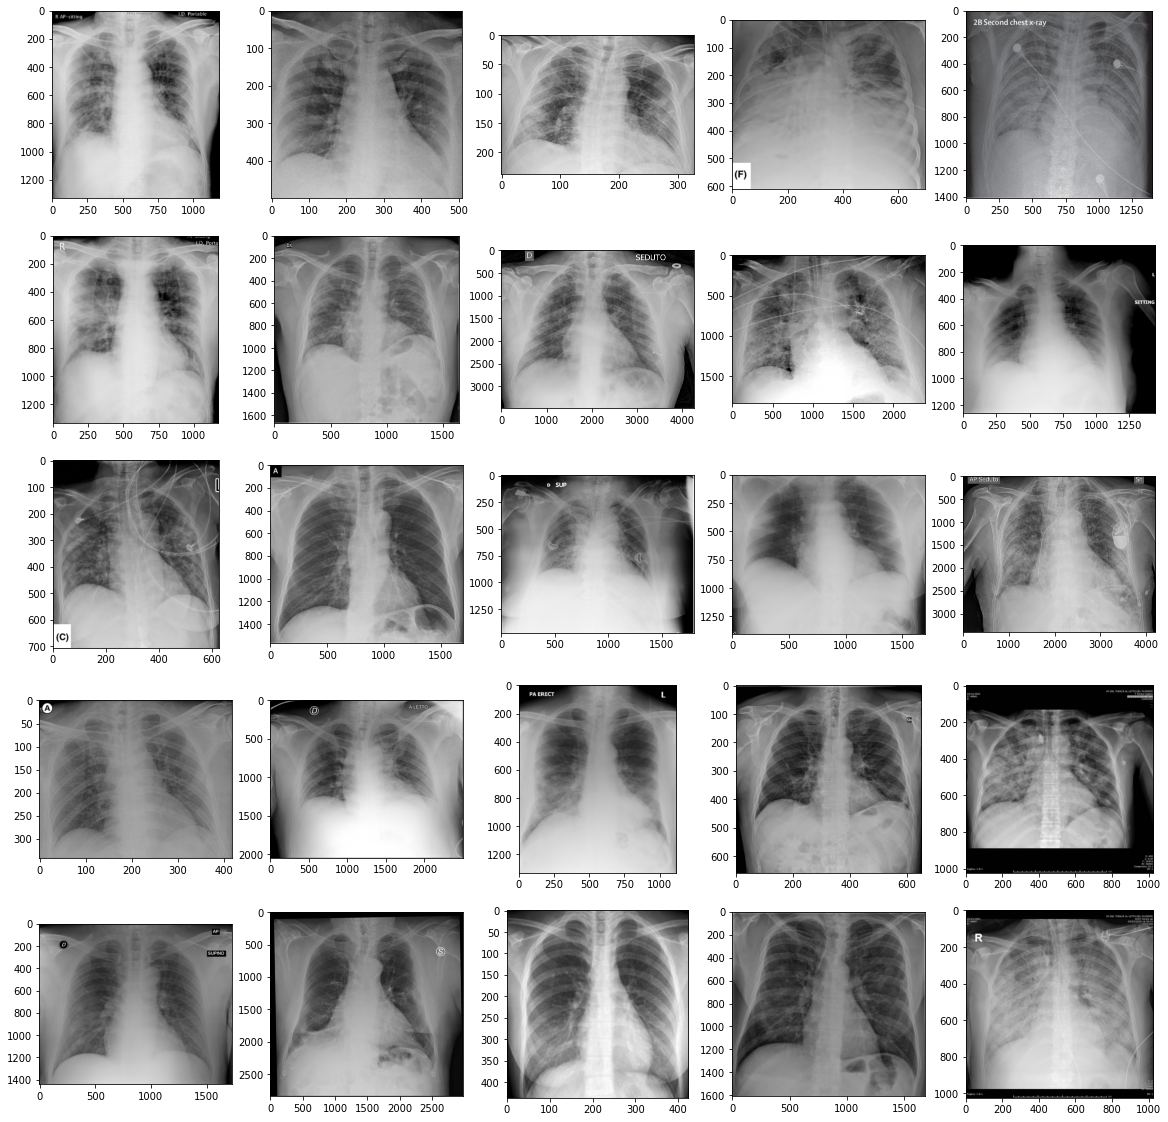

In [12]:
plot_samples(covid_file_list)

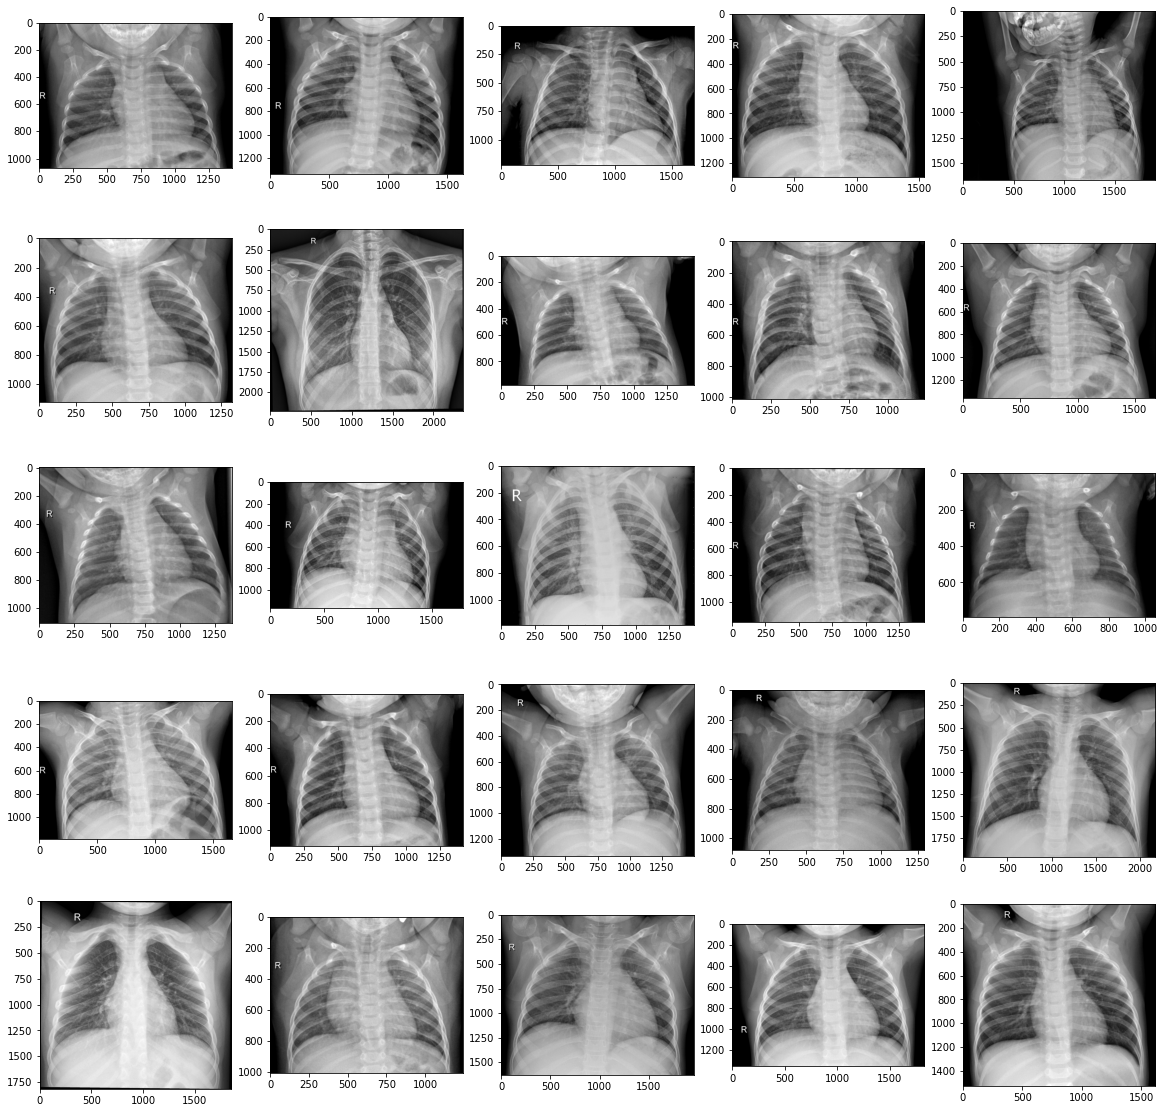

In [13]:
plot_samples(normal_file_list, label='NORMAL')

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        fill_mode="nearest",
        validation_split=0.2)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        fill_mode="nearest")

In [74]:
BATCH_SIZE = 4
train_generator = train_datagen.flow_from_directory(
        data_path + 'train/',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        classes=['covid', 'normal'],
        subset='training',
        shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    data_path + 'train/',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    classes=['covid', 'normal'],
    subset='validation',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    data_path + 'test/',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False)

Found 108 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [0]:
base_model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

stacked_model = base_model.output
stacked_model = AveragePooling2D(pool_size=(4, 4))(stacked_model)
stacked_model = Flatten(name="flatten")(stacked_model)
stacked_model = Dense(64, activation="relu")(stacked_model)
stacked_model = Dropout(0.5)(stacked_model)
stacked_model = Dense(2, activation="softmax")(stacked_model)

model = Model(inputs=base_model.input, outputs=stacked_model)

for layer in base_model.layers:
	layer.trainable = False

In [40]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [41]:
initial_lr = 0.01
EPOCHS = 20
adam = Adam(lr=initial_lr, decay=initial_lr / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=adam,
	metrics=["accuracy"])

history = model.fit_generator(
	train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
	epochs=EPOCHS)

Epoch 1/20
27/27 [==============================] - 11s 393ms/step - loss: 0.9907 - accuracy: 0.5556 - val_loss: 0.4905 - val_accuracy: 1.0000
Epoch 2/20
27/27 [==============================] - 9s 351ms/step - loss: 0.4906 - accuracy: 0.7685 - val_loss: 0.2833 - val_accuracy: 0.9583
Epoch 3/20
27/27 [==============================] - 10s 352ms/step - loss: 0.3553 - accuracy: 0.8426 - val_loss: 0.1540 - val_accuracy: 0.9583
Epoch 4/20
27/27 [==============================] - 10s 354ms/step - loss: 0.3274 - accuracy: 0.8333 - val_loss: 0.1527 - val_accuracy: 0.9583
Epoch 5/20
27/27 [==============================] - 10s 353ms/step - loss: 0.2768 - accuracy: 0.8519 - val_loss: 0.0840 - val_accuracy: 1.0000
Epoch 6/20
27/27 [==============================] - 9s 352ms/step - loss: 0.2205 - accuracy: 0.8796 - val_loss: 0.1028 - val_accuracy: 0.9583
Epoch 7/20
27/27 [==============================] - 9s 351ms/step - loss: 0.2067 - accuracy: 0.9167 - val_loss: 0.1408 - val_accuracy: 0.9583
Ep

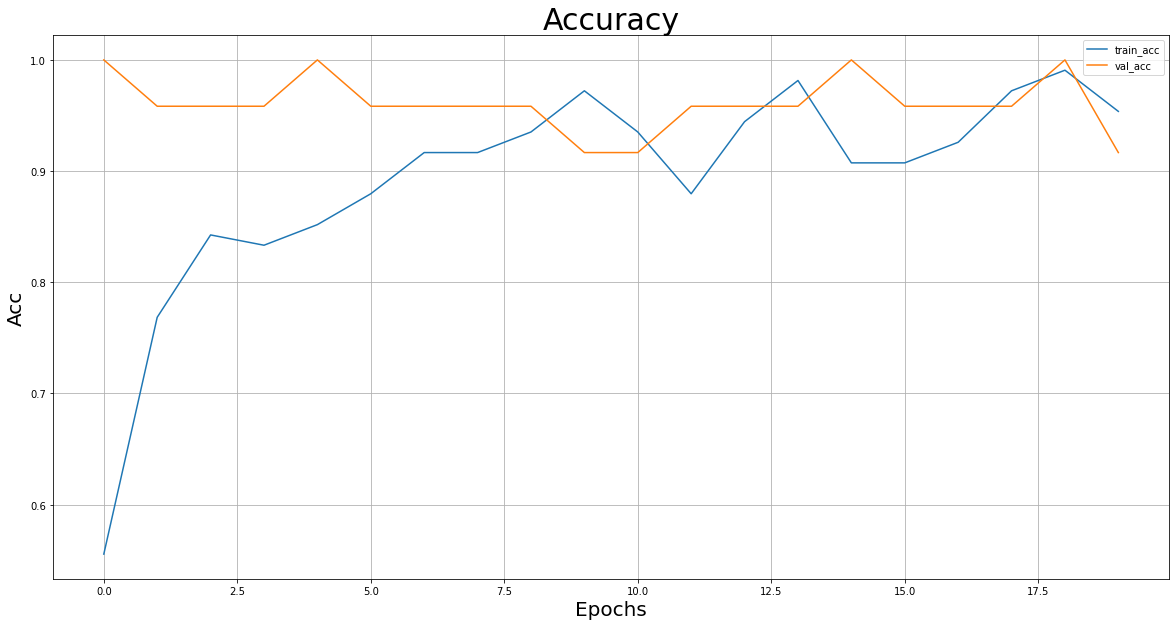

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy", fontsize=30)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Acc", fontsize=20)
plt.legend()
plt.grid()
plt.savefig("acc_result.png")

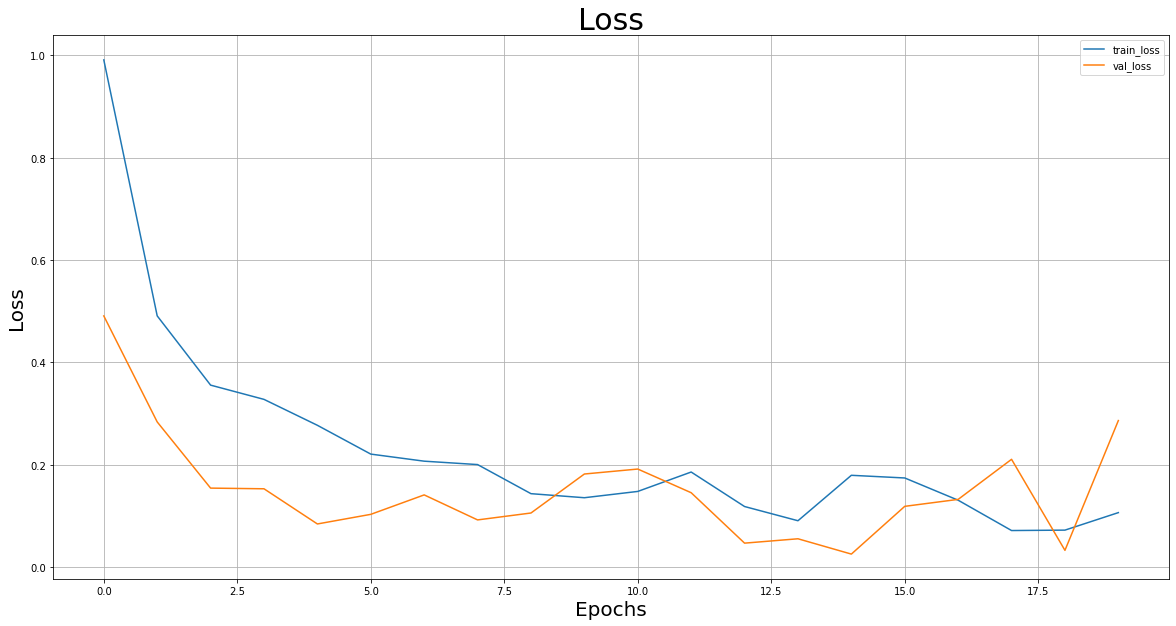

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss", fontsize=30)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.grid()
plt.savefig("loss_result.png")

In [0]:
preds = model.predict_generator(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE,
)

In [0]:
from sklearn import metrics

In [83]:
test_preds = np.argmax(preds, axis=-1)
test_trues = test_generator.classes
cm = metrics.confusion_matrix(test_trues, test_preds)
cm

array([[6, 0],
       [0, 6]])

In [0]:
from tensorflow.python.keras.utils.vis_utils import plot_model

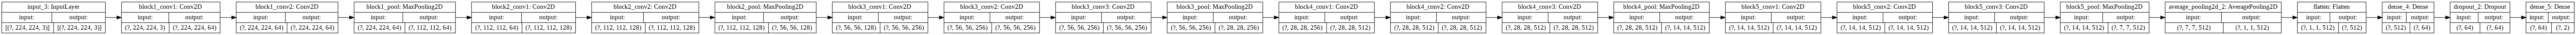

In [96]:
plot_model(model, to_file='model_archtecture.png', show_shapes=True, rankdir='LR')